In [1]:
!pip install torchvision
!pip install sagemaker

     |████████████████████████████████| 22.1 MB 30.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 116.9 MB/s eta 0:00:01
     |████████████████████████████████| 442 kB 32.7 MB/s eta 0:00:01
     |████████████████████████████████| 131 kB 111.6 MB/s eta 0:00:01
  Using cached protobuf3-to-dict-0.1.5.tar.gz (3.5 kB)
  Using cached smdebug_rulesconfig-1.0.1-py2.py3-none-any.whl (20 kB)
  Using cached pathos-0.2.8-py2.py3-none-any.whl (81 kB)
  Using cached s3transfer-0.5.0-py3-none-any.whl (79 kB)
     |████████████████████████████████| 7.9 MB 86.6 MB/s eta 0:00:01
  Using cached ppft-1.6.6.4-py3-none-any.whl (65 kB)
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
     |████████████████████████████████| 112 kB 126.9 MB/s eta 0:00:01
  Using cached pox-0.3.0-py2.py3-none-any.whl (30 kB)
  Created wheel for sagemaker: filename=sagemaker-2.59.2-py2.py3-none-any.whl size=618519 sha256=f99e2da31e95922f1cc615085236772b52c918f47b86d81d32a51620a95c62b2
  Stored in directo

### Import stuff

In [116]:
import time
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim

from torchvision import datasets
from torchvision import transforms
import torchvision.models as models

from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import torch.nn as nn
import pathlib

import random

### load data from S3 to folder of sagemaker instance

In [ ]:
import boto3

# When running on SageMaker, need execution role
from sagemaker import get_execution_role
role = get_execution_role()

# Declare bucket name, remote file, and destination
s3_bucket = "amazon-braket-a79a20b5e0b4"
orig_file = 'defect_data.zip'
dest_file = './defect_data.zip'

# Connect to S3 bucket and download file
s3 = boto3.resource('s3')
s3.Bucket(s3_bucket).download_file(orig_file, dest_file)

### unzip defect_data.zip 

In [ ]:
from zipfile import ZipFile

# Create a ZipFile Object and load sample.zip in it
with ZipFile('defect_data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('./defect_data')

### Data preparation 

In [117]:
def get_train_test_data(img_path, img_set_size = 40e3, test_set_ratio = 0.2):
    """
    Create train and test data with PyTorchs ImageFolder class.  
    """

    resolution = (227,227)
    
    img_dataset = datasets.ImageFolder(
        root=img_path,
        transform=transforms.Compose([
            transforms.Resize(resolution), # do not have to resize because all imgs are on 227x227
            transforms.ToTensor(),
            # maps values from [0, 1] to [-1,1]
            # 0.5 mean and 0.5 std deviation for each channel is a standard choice
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
        ]))
    
    # restrict size of data set
    # take n random indices out of full img_dataset size
    random_indices = random.sample(range(len(img_dataset)), img_set_size)

    img_dataset_subset = torch.utils.data.Subset(img_dataset, random_indices)
    
    # split data set into train and test set
    test_set_size = int(test_set_ratio * len(img_dataset_subset))
    train_set_size = len(img_dataset_subset) - test_set_size   
    train_set, test_set = random_split(img_dataset_subset, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(42))
    
    # with attribute class_to_idx we get a mapping from classes to labels. We invert the dict subsequently.
    label_to_class_dict = {value: key for key, value in img_dataset.class_to_idx.items()}

    return train_set, test_set, label_to_class_dict

### load data set

In [118]:
img_path = './defect_data'
train_set, test_set, label_to_class_dict = get_train_test_data(img_path, img_set_size = 1000)


BATCH_SIZE = 32 

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [119]:
len(train_set)

800

In [120]:
len(test_set)

200

### train functions

In [121]:
def get_plain_accuracy(y_pred, y_true):
    return (y_pred.argmax(dim=1) == y_true).float().mean()


def eval_test_set(model, best_loss, model_name, run_idx):
    print("### Eval test set ###")

    model.eval()
    loss_fn = torch.nn.CrossEntropyLoss(reduction = 'mean')
    
    y_test_pred = torch.tensor([]).float()
    y_test_true = torch.tensor([]).long()  
    
    start_time = time.time()
    
    # forward pass is faster with torch.no_grad()
    with torch.no_grad(): 
            
        for x_test_batch, y_test_true_batch in test_loader:
            
            y_test_pred_batch = model(x_test_batch)
            
            y_test_pred = torch.cat([y_test_pred, y_test_pred_batch])
            y_test_true = torch.cat([y_test_true, y_test_true_batch])            
                    
    loss_test = loss_fn(y_test_pred, y_test_true)
    acc_test = get_plain_accuracy(y_test_pred, y_test_true)

    print(f"Loss test: {loss_test:.3f}")
    print(f"Accuracy test: {acc_test:.3f}") 
    print(f'Time {(time.time() - start_time):.2f}')

    # save best_model
    if loss_test < best_loss:
        state = {
            'state_dict': model.state_dict()
        }
#         torch.save(state, f'./models/{model_name}_best_model_run_{run_idx}.h5')
        best_loss = loss_test
        
    print("#####################\n")    
    return best_loss, loss_test, acc_test  


def train(model, num_epochs, run_idx, model_name="resnet"):
    """Train function"""
    

    # define loss and optimizer
    loss_fn = torch.nn.CrossEntropyLoss(reduction = 'mean')
    optimizer = optim.Adam(model.parameters())

    acc_train_list = []
    loss_train_list = []    
    
    acc_test_list = []    
    loss_test_list = []   
    
    best_loss = 10e3
    
    for epoch in range(num_epochs):

        print(f'### Epoch {epoch} ###\n')

        for idx, (x_train, y_true) in enumerate(train_loader):

            model.train()
            
            start_time = time.time()
            
            print(f'Batch iter/total {idx}/{len(train_loader)-1}')
            # zero the gradients
            optimizer.zero_grad()

            # do one forward pass
            y_pred = model(x_train)             

            # calculate the loss
            loss = loss_fn(y_pred, y_true)
            acc_train = get_plain_accuracy(y_pred, y_true)

            print(f"Loss train: {loss:.3f}")
            print(f"Accuracy train: {acc_train:.3f}")

            # get gradients with respect to that loss
            loss.backward()

            # actual optimizing step
            optimizer.step()

            acc_train_list.append(acc_train.item())
            loss_train_list.append(loss.item())
            
            print(f'Time per batch_iter {(time.time() - start_time):.2f}\n')
        
            # eval test set every 5 iters
            if ((idx + 1) % 5) == 0:
                best_loss, loss_test, acc_test = eval_test_set(model, best_loss, model_name,run_idx)
                
                acc_test_list.append(acc_test.item())
                loss_test_list.append(loss_test.item())
                
    return acc_train_list, acc_test_list, loss_train_list, loss_test_list


def plot_stuff(data_, title, plot_each_metric=False):
    
    data = data_.mean(axis=0)
    std = data_.std(axis=0)
    
    plt.figure(figsize=(9,5))
    plt.title(title)
    plt.plot(data)
    
    if plot_each_metric:
        plt.plot(data_.T)
    
    plt.fill_between(range(len(data)), data - std, data + std, color='tab:blue', alpha=0.15)
                 
    plt.grid()
    plt.show()

### load pretrained resnet 18 and freeze all conv layers

In [122]:

def run_experiment(num_runs, num_epochs, nn_type, q_depth=None):
    # start training process and measure time duration
    start_time = time.time()

    avg_acc_train = np.array([])
    avg_acc_test = np.array([])

    avg_loss_train = np.array([])
    avg_loss_test = np.array([])

    for run_idx in range(num_runs):

        # load on ImageNet pretrained resnet18
        model = models.resnet18(pretrained=True)

        # freeze all layers
        for name, param in model.named_parameters():
            param.requires_grad = False

        # attach new last classic or quantum layer
        if nn_type == 'classic':
            model.fc = nn.Linear(512, 2)  
            model_name="resnet"
            
        elif nn_type == 'angular':
            model.fc = QuantumNetAngularEmbedding(q_depth = q_depth)
            model_name=f"resnet_q_angular_depth{q_depth}"
            
        elif nn_type == 'amplitude':
            model.fc = QuantumNetAmplitudeEmbedding(n_qubits=9, q_depth=q_depth)
            model_name=f"resnet_q_amplitude_depth{q_depth}"    
            
        if  run_idx == 0:  
            print(f'########## {model_name} ##########')
        print(f'\n########## run {run_idx} ##########\n')

        acc_train, acc_test, loss_train, loss_test = train(model=model, num_epochs = num_epochs, run_idx= run_idx,model_name=model_name)

        avg_acc_train = np.vstack([avg_acc_train, np.array(acc_train)]) if avg_acc_train.size else np.array(acc_train)  
        avg_acc_test = np.vstack([avg_acc_test, np.array(acc_test)]) if avg_acc_test.size else np.array(acc_test)  

        avg_loss_train = np.vstack([avg_loss_train, np.array(loss_train)]) if avg_loss_train.size else np.array(loss_train)  
        avg_loss_test = np.vstack([avg_loss_test, np.array(loss_test)]) if avg_loss_test.size else np.array(loss_test)        

    total_time = time.time() - start_time

    print(f'total time taken {total_time:.2f}\n')
    
    
    # create folder if not exists
    pathlib.Path(f"./metrics/{model_name}").mkdir(parents=True, exist_ok=True)
    
#     # store metrics
#     np.save(f'./metrics/{model_name}/avg_acc_test.npy', avg_acc_test)
#     np.save(f'./metrics/{model_name}/avg_acc_train.npy', avg_acc_train)

#     np.save(f'./metrics/{model_name}/avg_loss_train.npy', avg_loss_train)
#     np.save(f'./metrics/{model_name}/avg_loss_test.npy', avg_loss_test)
    
    return avg_acc_train.T, avg_acc_test.T, avg_loss_train.T, avg_loss_test.T
    
    

## Train CNN classically

In [123]:
num_runs = 3
num_epochs = 4

In [11]:

# avg_acc_train, avg_acc_test, avg_loss_train, avg_loss_test = run_experiment(num_runs, num_epochs, nn_type='classic')

max average test accuracy 0.992


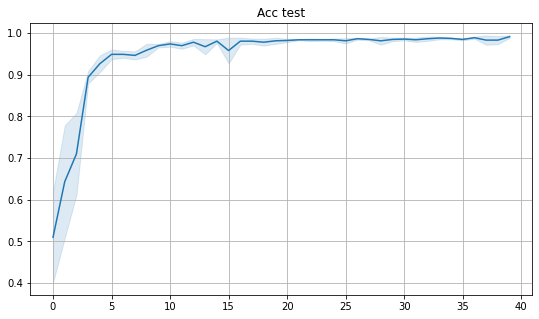

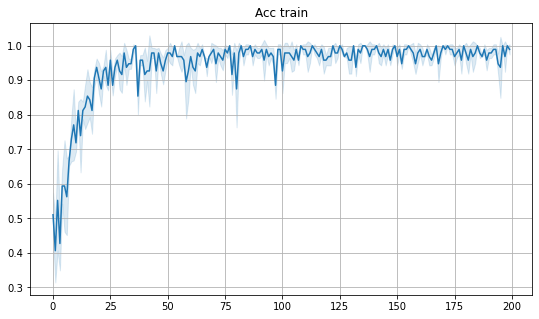

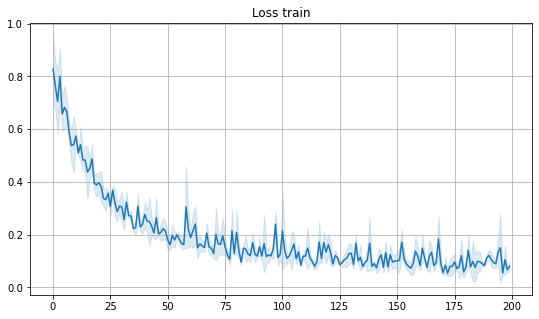

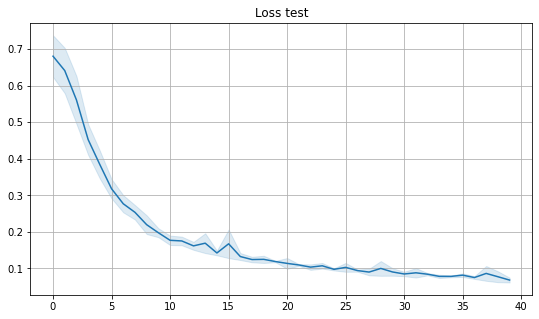

In [12]:

avg_acc_test = np.load('./metrics/resnet/avg_acc_test.npy')
avg_acc_train = np.load('./metrics/resnet/avg_acc_train.npy')

avg_loss_train = np.load('./metrics/resnet/avg_loss_train.npy')
avg_loss_test = np.load('./metrics/resnet/avg_loss_test.npy')

print(f'max average test accuracy {max(avg_acc_test.mean(axis=0)):.3f}')

plot_stuff(avg_acc_test, title = 'Acc test')
plot_stuff(avg_acc_train, title = 'Acc train')

plot_stuff(avg_loss_train, title = 'Loss train')
plot_stuff(avg_loss_test, title = 'Loss test')


### Quantum Net 

In [124]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np

In [125]:
# hyperparameters of quantum net

n_qubits = 4        

init_param_spread = 0.01 # Initial spread of random quantum weights

dev = qml.device("braket.local.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [126]:


def entangling_layer(n_qubits = n_qubits, pattern = 'chain'):
    """pattern in ('chain', 'ring', 'all_to_all')"""
    
    if pattern not in ('chain', 'ring', 'all_to_all', 'random'):
        pattern = 'chain'
    if pattern is not 'random':
        qml.broadcast(qml.CNOT, wires = list(range(n_qubits)), pattern = pattern)
    else:
        q_idx_list = list(range(n_qubits))
        np.random.shuffle(q_idx_list)
        for i in range(n_qubits - 1):
            qml.CNOT(wires = [q_idx_list[i], q_idx_list[i + 1]])
        qml.CNOT(wires = [q_idx_list[-1], q_idx_list[0]])

def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def amplitude_embedding(q_input_features, n_qubits = n_qubits):
    """Transfers a given input feature into a quantum statevector. 2**9 = 512"""

    
    assert len(q_input_features) == 2**n_qubits, "Input Features must be of dimension 2**n_qubits"
    
    wires_list = list(range(n_qubits))
    
    # TODO: replace equality comparison to one with tolerance
    normalize = not (np.linalg.norm(q_input_features) == 1)
            
    qml.templates.AmplitudeEmbedding(features = q_input_features, 
                                     wires = wires_list, 
                                     normalize = normalize) 
        
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits = n_qubits, pattern = 'ring')
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)




#### draw circuit

In [127]:
q_depth = 1
n_qubits = 4
q_input_features = (torch.rand(n_qubits) * 2 - 1) * np.pi / 2
q_weights_flat = torch.randn(q_depth * n_qubits)

# evaluation of the circuit is necessary to draw the circuit 
result = quantum_net(q_input_features, q_weights_flat)

print(quantum_net.draw())

 0: ──H──RY(1.2)─────╭C─────────────────────────────╭X──RY(1.11)───┤ ⟨Z⟩ 
 1: ──H──RY(1.1)─────╰X──╭C───RY(0.0499)────────────│──────────────┤ ⟨Z⟩ 
 2: ──H──RY(-0.526)──────╰X──╭C───────────RY(1.34)──│──────────────┤ ⟨Z⟩ 
 3: ──H──RY(-1.03)───────────╰X─────────────────────╰C──RY(0.366)──┤ ⟨Z⟩ 



In [128]:
my_bucket = "amazon-braket-a79a20b5e0b4"  # the name of the bucket
my_prefix = "amplitude-embbing"  # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [134]:
# amplitude embedding 
n_qubits = 9
q_input_features = torch.randn(2 ** n_qubits)

q_weights_flat = torch.randn(q_depth * n_qubits)

# evaluation of the circuit is necessary to draw the circuit 

# dev = qml.device("braket.local.qubit", wires=n_qubits)
dev = qml.device("braket.local.qubit", wires=n_qubits)


# # evaluation of the circuit is necessary to draw the circuit 
# device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
# dev = qml.device("braket.aws.qubit", wires=n_qubits, device_arn=device_arn, parallel=True, s3_destination_folder=s3_folder)


print(q_input_features.shape)


@qml.qnode(dev, interface="torch")
def quantum_net_amplitude(q_weights_flat, q_input_features=None ):
    """
    The variational quantum circuit with amplitude embedding
    """
    print('q_weights_flat.shape',q_weights_flat.shape)
    print('q_input_features.shape',q_input_features.shape)
    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    amplitude_embedding(q_input_features, n_qubits)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits = n_qubits, pattern = 'ring')
        RY_layer(q_weights[k])

#     # Expectation values in the Z basis
#     exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    
#     # Why do we return tuple here?
#     return tuple(exp_vals)
    return qml.expval(qml.PauliZ(0)) 

result = quantum_net_amplitude(q_weights_flat, q_input_features)

# print(quantum_net_amplitude.draw())

result

torch.Size([512])
q_weights_flat.shape torch.Size([9])
q_input_features.shape torch.Size([512])


tensor(-0.0463, dtype=torch.float64)

In [130]:
class QuantumNetAngularEmbedding(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self, q_depth):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(init_param_spread * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)
    
class QuantumNetAmplitudeEmbedding(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self, n_qubits, q_depth):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        
        self.q_params = nn.Parameter(init_param_spread * torch.randn(q_depth * n_qubits))

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits )
        q_out = q_out.to(device)
        
        # iterate over each element of the batch
        for elem in input_features:
            q_out_elem = quantum_net_amplitude(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # restrict to first two dimensions and ignore the rest
        return nn.Sigmoid(q_out)

### Train Quantum CNN with angular embedding for different depth sizes

In [21]:

# for q_depth in [1]:

#     q_avg_acc_train, q_avg_acc_test, q_avg_loss_train, q_avg_loss_test = run_experiment(num_runs, num_epochs, nn_type = 'angular', q_depth = q_depth)

#### DEPTH 1 ####
max average test accuracy 0.948


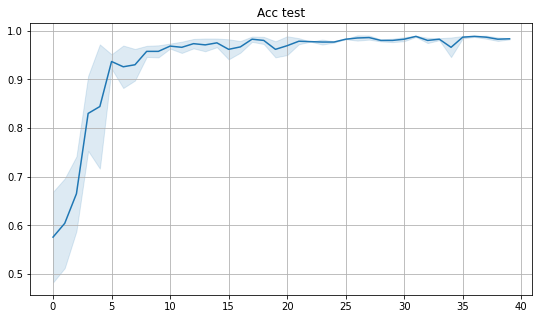

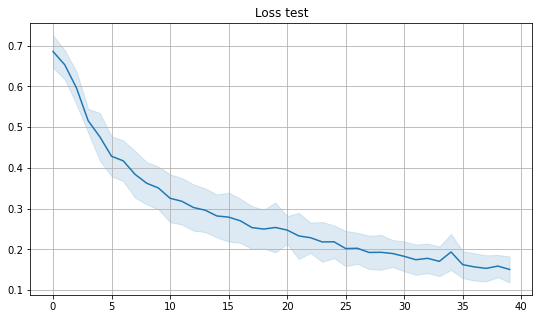

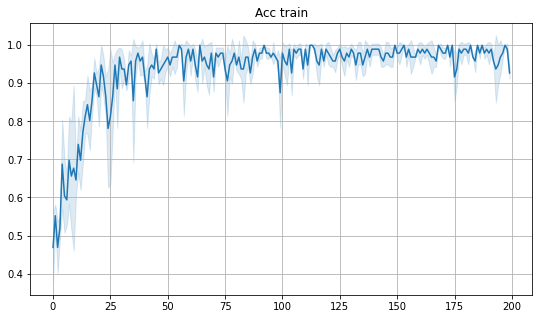

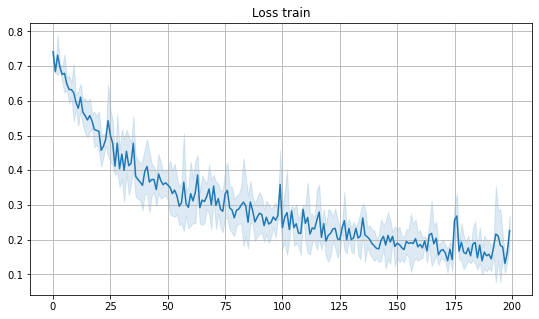

#### DEPTH 5 ####
max average test accuracy 0.951


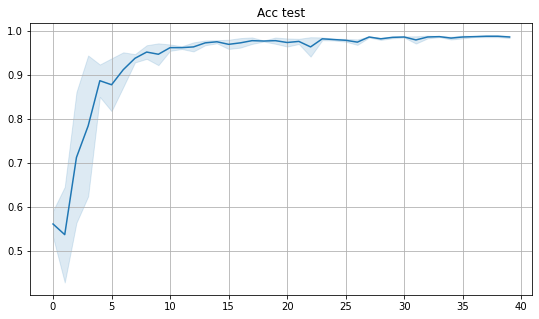

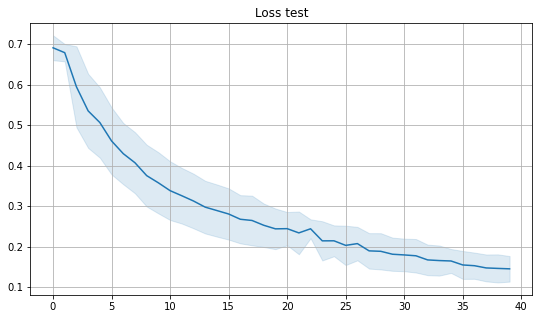

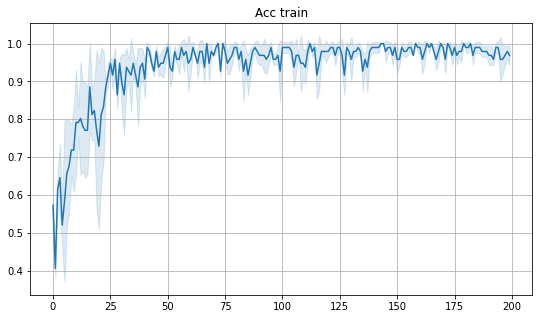

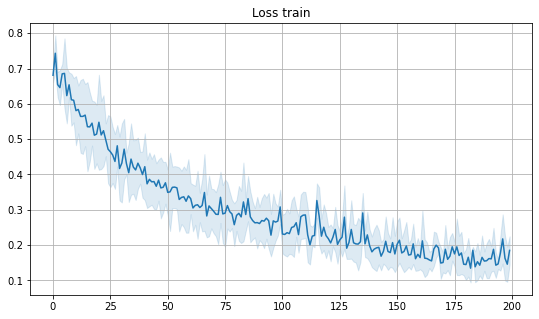

In [22]:
for q_depth in [1,5]:
    
    model_name=f"resnet_q_angular_depth{q_depth}"
    
    # load quantum metrics
    q_avg_acc_test = np.load(f'./metrics/{model_name}/avg_acc_test.npy')
    q_avg_acc_train = np.load(f'./metrics/{model_name}/avg_acc_train.npy')

    q_avg_loss_train = np.load(f'./metrics/{model_name}/avg_loss_train.npy')
    q_avg_loss_test = np.load(f'./metrics/{model_name}/avg_loss_test.npy')
    
    print(f'#### DEPTH {q_depth} ####')
#     print(q_avg_acc_test)
    
    print(f'max average test accuracy {max(q_avg_acc_test.mean(axis=1)):.3f}')

    plot_stuff(q_avg_acc_test, title = 'Acc test',plot_each_metric=False)
    plot_stuff(q_avg_loss_test, title = 'Loss test',plot_each_metric=False)
    
    plot_stuff(q_avg_acc_train, title = 'Acc train',plot_each_metric=False)
    plot_stuff(q_avg_loss_train, title = 'Loss train',plot_each_metric=False)




### Plot everything combined 

In [83]:
def plot_stuff_combined(data_list, labels_list, title):
    
    plt.figure(figsize=(12,7))
    for idx, data_ in enumerate(data_list):

        data = data_.mean(axis=0)
        std = data_.std(axis=0)

        plt.title(title)

        plt.plot(data, label=labels_list[idx])

        plt.fill_between(range(len(data)), data - std, data + std, alpha=0.15)
        
    plt.legend()
    plt.grid()
    plt.show()

########## resnet_q_angular_depth1 ##########
########## resnet_q_angular_depth5 ##########


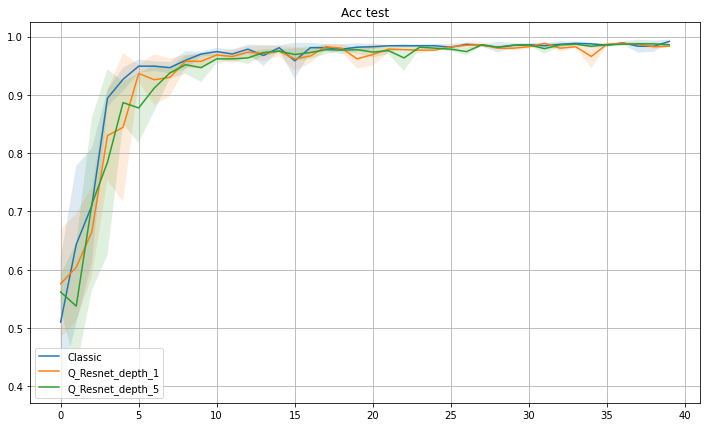

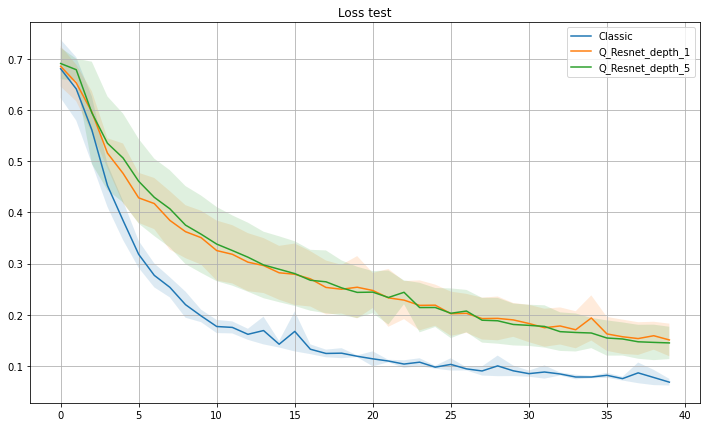

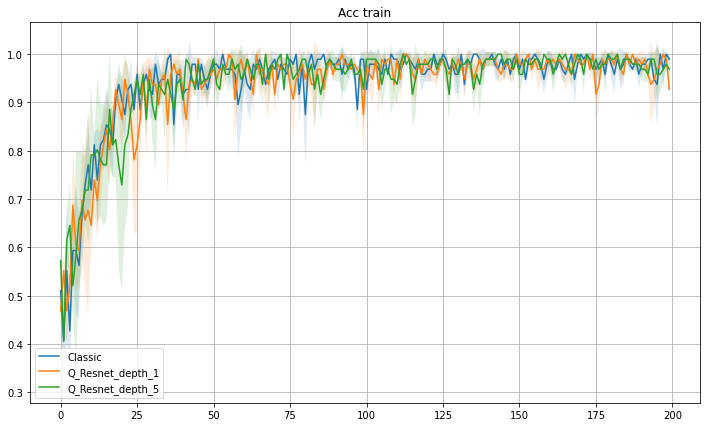

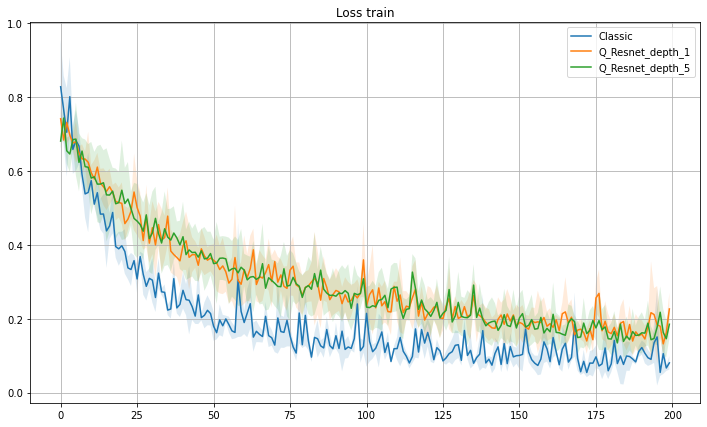

In [40]:
# load classic metrics 
avg_acc_test = np.load('./metrics/resnet/avg_acc_test.npy')
avg_acc_train = np.load('./metrics/resnet/avg_acc_train.npy')

avg_loss_train = np.load('./metrics/resnet/avg_loss_train.npy')
avg_loss_test = np.load('./metrics/resnet/avg_loss_test.npy')

acc_test_list = []
acc_train_list = []

loss_test_list = []
loss_train_list = []

labels_list = []

acc_test_list.append(avg_acc_test)
acc_train_list.append(avg_acc_train)

loss_test_list.append(avg_loss_test)
loss_train_list.append(avg_loss_train)

labels_list.append("Classic")


for q_depth in [1,5]:
    
    model_name=f"resnet_q_angular_depth{q_depth}"
    
    print(f'########## {model_name} ##########')

    # load quantum metrics
    avg_acc_test = np.load(f'./metrics/{model_name}/avg_acc_test.npy')
    avg_acc_train = np.load(f'./metrics/{model_name}/avg_acc_train.npy')

    avg_loss_train = np.load(f'./metrics/{model_name}/avg_loss_train.npy')
    avg_loss_test = np.load(f'./metrics/{model_name}/avg_loss_test.npy')
    
    acc_test_list.append(avg_acc_test)
    acc_train_list.append(avg_acc_train)

    loss_test_list.append(avg_loss_test)
    loss_train_list.append(avg_loss_train)
    
    labels_list.append(f"Q_Resnet_depth_{q_depth}")

# plot in one plot
plot_stuff_combined(acc_test_list, labels_list, title = 'Acc test')
plot_stuff_combined(loss_test_list, labels_list, title = 'Loss test')

plot_stuff_combined(acc_train_list, labels_list, title = 'Acc train')
plot_stuff_combined(loss_train_list, labels_list, title = 'Loss train')

### Train QNN with amplitude embedding

In [56]:
num_runs = 3
num_epochs = 4
for q_depth in [1]:

    q_avg_acc_train, q_avg_acc_test, q_avg_loss_train, q_avg_loss_test = run_experiment(num_runs, num_epochs, nn_type = 'amplitude', q_depth = q_depth)

########## resnet_q_amplitude_depth1 ##########

########## run 0 ##########

### Epoch 0 ###

Batch iter/total 0/49
Loss train: 0.688
Accuracy train: 0.500
Time per batch_iter 94.67

Batch iter/total 1/49
Loss train: 0.702
Accuracy train: 0.438


KeyboardInterrupt: 

### evaluate forward backward passes of example circuit

In [131]:
n_wires = 25

device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

dev_remote = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=n_wires,
    s3_destination_folder=s3_folder,
    parallel=True,
)

dev_local = qml.device("default.qubit", wires=n_wires)
dev_local_braket = qml.device("braket.local.qubit", wires=n_wires)

In [132]:
def circuit(params):
    for i in range(n_wires):
        qml.RX(params[i], wires=i)
    for i in range(n_wires):
        qml.CNOT(wires=[i, (i + 1) % n_wires])
    return qml.expval(qml.PauliZ(n_wires - 1))

In [133]:
qnode_remote = qml.QNode(circuit, dev_remote)
qnode_local = qml.QNode(circuit, dev_local)
qnode_local_braket = qml.QNode(circuit, dev_local)

### forward pass

In [103]:
import time
n_wires = 25
params = np.random.random(n_wires)

t_0_remote = time.time()
qnode_remote(params)
t_1_remote = time.time()

t_0_local = time.time()
qnode_local(params)
t_1_local = time.time()

t_0_local_braket = time.time()
qnode_local_braket(params)
t_1_local_braket = time.time()

print("Execution time on remote device (seconds):", t_1_remote - t_0_remote)
print("Execution time on local device (seconds):", t_1_local - t_0_local)
print("Execution time on local braket device (seconds):", t_1_local_braket - t_0_local_braket)

Execution time on remote device (seconds): 3.7660419940948486
Execution time on local device (seconds): 26.023966789245605
Execution time on local braket device (seconds): 25.794980764389038


### backward

In [104]:
d_qnode_remote = qml.grad(qnode_remote)

t_0_remote_grad = time.time()
d_qnode_remote(params)
t_1_remote_grad = time.time()

print("Gradient calculation time on remote device (seconds):", t_1_remote_grad - t_0_remote_grad)

Gradient calculation time on remote device (seconds): 24.3712100982666


### evaluate quantum net with amplitude embedding

In [140]:
def quantum_net_amplitude(q_weights_flat, q_input_features=None):
    """
    The variational quantum circuit with amplitude embedding
    """
    
    # Reshape weights
    
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    
    amplitude_embedding(q_input_features, n_qubits)

    # Sequence of trainable variational layers
    start_time = time.time()
    
    for k in range(q_depth):
        entangling_layer(n_qubits = n_qubits, pattern = 'ring')
        RY_layer(q_weights[k])

    return qml.expval(qml.PauliZ(0))

q_depth = 1
n_wires = 9

qnode_remote = qml.QNode(quantum_net_amplitude, dev_remote)
qnode_local = qml.QNode(quantum_net_amplitude, dev_local)
qnode_local_braket = qml.QNode(quantum_net_amplitude, dev_local_braket)

params = np.random.random(n_wires,requires_grad = True)

q_input_features =  np.random.random(512,requires_grad=False)

result = qnode_remote(q_weights_flat, q_input_features)

print(qnode_remote.draw())

result = qnode_local(q_weights_flat, q_input_features)

print(qnode_local.draw())

result = qnode_local_braket(q_weights_flat, q_input_features)

print(qnode_local.draw())

 0: ──RY(1.58)──╭C──────────────╭C───────────────────╭C─────────────────────────────────╭C─────────────────────────────────────────────────────╭C──────────────────────────────────────────────────────────────╭C─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╭C─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╭C──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╭C────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╭C───────────────────

#### forward pass for quantum net

In [107]:
import time


t_0_remote = time.time()
qnode_remote(params, q_input_features)
t_1_remote = time.time()

print("Execution time on remote device (seconds):", t_1_remote - t_0_remote)

t_0_local = time.time()
qnode_local(params, q_input_features)
t_1_local = time.time()

print("Execution time on local device (seconds):", t_1_local - t_0_local)

t_0_local_braket = time.time()
qnode_local_braket(params, q_input_features)
t_1_local_braket = time.time()

print("Execution time on local_braket device (seconds):", t_1_local_braket - t_0_local_braket)



Execution time on remote device (seconds): 12.436975240707397
Execution time on local device (seconds): 7.998316764831543
Execution time on local_braket device (seconds): 358.14894676208496


#### gradient calculation for quantum net 

In [110]:
d_qnode_remote = qml.grad(qnode_remote)

t_0_remote_grad = time.time()
d_qnode_remote(params, q_input_features)
t_1_remote_grad = time.time()

print("Gradient calculation time on remote device (seconds):", t_1_remote_grad - t_0_remote_grad)

d_qnode_local = qml.grad(qnode_local)

t_0_local_grad = time.time()
d_qnode_local(params, q_input_features)
t_1_local_grad = time.time()

print("Gradient calculation time on local device (seconds):", t_1_local_grad - t_0_local_grad)

d_qnode_local_braket = qml.grad(qnode_local_braket)

t_0_local_braket_grad = time.time()
d_qnode_local_braket(params, q_input_features)
t_1_local_braket__grad = time.time()

print("Gradient calculation time on local braket device (seconds):", t_1_local_braket__grad - t_0_local_braket_grad)

Gradient calculation time on remote device (seconds): 26.91490888595581
Gradient calculation time on local device (seconds): 13.693583965301514
Gradient calculation time on local braket device (seconds): 1087.441795349121


### quantum net with hadamard instead of amplitude 



In [111]:
def quantum_net_amplitude(q_weights_flat, q_input_features=None):
    """
    The variational quantum circuit with amplitude embedding
    """

    # Reshape weights
    
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    

#     amplitude_embedding(q_input_features, n_qubits)

#     # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)
    
    # Sequence of trainable variational layers
    start_time = time.time()
    
    for k in range(q_depth):
        entangling_layer(n_qubits = n_qubits, pattern = 'ring')
        RY_layer(q_weights[k])
        

    return qml.expval(qml.PauliZ(0)) 

In [112]:
q_depth = 1
n_wires = 9

qnode_remote = qml.QNode(quantum_net_amplitude, dev_remote,)
qnode_local = qml.QNode(quantum_net_amplitude, dev_local)
qnode_local_braket = qml.QNode(quantum_net_amplitude, dev_local_braket)


params = np.random.randn(n_wires, requires_grad=True)
q_input_features = np.random.randn(512, requires_grad=False)

In [113]:
import time

t_0_remote = time.time()
qnode_remote(params, q_input_features)
t_1_remote = time.time()

print("Execution time on remote device (seconds):", t_1_remote - t_0_remote)

t_0_local = time.time()
qnode_local(params, q_input_features)
t_1_local = time.time()

print("Execution time on local device (seconds):", t_1_local - t_0_local)

t_0_local_braket = time.time()
qnode_local_braket(params, q_input_features)
t_1_local_braket = time.time()

print("Execution time on local_braket device (seconds):", t_1_local_braket - t_0_local_braket)



Execution time on remote device (seconds): 3.987250566482544
Execution time on local device (seconds): 11.115440607070923
Execution time on local_braket device (seconds): 14.957247972488403


In [114]:
d_qnode_remote = qml.grad(qnode_remote)

t_0_remote_grad = time.time()
d_qnode_remote(params, q_input_features)
t_1_remote_grad = time.time()

print("Gradient calculation time on remote device (seconds):", t_1_remote_grad - t_0_remote_grad)

d_qnode_local = qml.grad(qnode_local)

t_0_local_grad = time.time()
d_qnode_local(params, q_input_features)
t_1_local_grad = time.time()

print("Gradient calculation time on local device (seconds):", t_1_local_grad - t_0_local_grad)

d_qnode_local_braket = qml.grad(qnode_local_braket)

t_0_local_braket_grad = time.time()
d_qnode_local_braket(params, q_input_features)
t_1_local_braket__grad = time.time()

print("Gradient calculation time on local braket device (seconds):", t_1_local_braket__grad - t_0_local_braket_grad)

Gradient calculation time on remote device (seconds): 8.636165380477905
Gradient calculation time on local device (seconds): 17.02194881439209
Gradient calculation time on local braket device (seconds): 44.585872650146484


### forward pass with pytorch interface und hadamard gate

In [138]:


def quantum_net_amplitude(q_weights_flat, q_input_features=None):
    """
    The variational quantum circuit with amplitude embedding
    """

    # Reshape weights
    
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    

#     amplitude_embedding(q_input_features, n_qubits)

#     # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)
    
    # Sequence of trainable variational layers
    start_time = time.time()
    
    for k in range(q_depth):
        entangling_layer(n_qubits = n_qubits, pattern = 'ring')
        RY_layer(q_weights[k])
        
    return qml.expval(qml.PauliZ(0)) 


qnode_remote = qml.QNode(quantum_net_amplitude, dev_remote, interface='torch')
qnode_local = qml.QNode(quantum_net_amplitude, dev_local, interface='torch')
qnode_local_braket = qml.QNode(quantum_net_amplitude, dev_local_braket, interface='torch')

n_wires = 9
                               
params = torch.randn(n_wires, requires_grad=True)
q_input_features = torch.randn(512, requires_grad=False)
                               
import time

########## FORWARD ##############

t_0_remote = time.time()
result_remote = qnode_remote(params, q_input_features)
t_1_remote = time.time()

print("Execution time on remote device (seconds):", t_1_remote - t_0_remote)

t_0_local = time.time()
result_local = qnode_local(params, q_input_features)
t_1_local = time.time()

print("Execution time on local device (seconds):", t_1_local - t_0_local)

t_0_local_braket = time.time()
result_local_braket = qnode_local_braket(params, q_input_features)
t_1_local_braket = time.time()

print("Execution time on local_braket device (seconds):", t_1_local_braket - t_0_local_braket)

print()
########## BACKWARD ###########

t_0_remote_grad = time.time()
result_remote.backward()
t_1_remote_grad = time.time()

print("Gradient calculation time on remote device (seconds):", t_1_remote_grad - t_0_remote_grad)
                               
                               
t_0_local_grad = time.time()                               
result_local.backward()  
t_1_local_grad = time.time()

print("Gradient calculation time on local device (seconds):", t_1_local_grad - t_0_local_grad)                               

t_0_local_braket_grad = time.time()                               
result_local_braket.backward()    
t_1_local_braket__grad = time.time()                               
print("Gradient calculation time on local braket device (seconds):", t_1_local_braket__grad - t_0_local_braket_grad)

Execution time on remote device (seconds): 3.7769789695739746
Execution time on local device (seconds): 12.722635984420776
Execution time on local_braket device (seconds): 14.682942390441895

Gradient calculation time on remote device (seconds): 2.7131052017211914
Gradient calculation time on local device (seconds): 25.440346240997314
Gradient calculation time on local braket device (seconds): 29.381813526153564


### forward pass with pytorch interface und amplitude embedding

In [139]:


def quantum_net_amplitude(q_weights_flat, q_input_features=None):
    """
    The variational quantum circuit with amplitude embedding
    """

    # Reshape weights
    
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    

    amplitude_embedding(q_input_features, n_qubits)

#     # Start from state |+> , unbiased w.r.t. |0> and |1>
#     H_layer(n_qubits)
    
    # Sequence of trainable variational layers
    start_time = time.time()
    
    for k in range(q_depth):
        entangling_layer(n_qubits = n_qubits, pattern = 'ring')
        RY_layer(q_weights[k])
        
    return qml.expval(qml.PauliZ(0)) 


qnode_remote = qml.QNode(quantum_net_amplitude, dev_remote, interface='torch')
qnode_local = qml.QNode(quantum_net_amplitude, dev_local, interface='torch')
qnode_local_braket = qml.QNode(quantum_net_amplitude, dev_local_braket, interface='torch')

n_wires = 9
                               
params = torch.randn(n_wires, requires_grad=True)
q_input_features = torch.randn(512, requires_grad=False)
                               
import time

########## FORWARD ##############

t_0_remote = time.time()
result_remote = qnode_remote(params, q_input_features)
t_1_remote = time.time()

print("Execution time on remote device (seconds):", t_1_remote - t_0_remote)

t_0_local = time.time()
result_local = qnode_local(params, q_input_features)
t_1_local = time.time()

print("Execution time on local device (seconds):", t_1_local - t_0_local)

t_0_local_braket = time.time()
result_local_braket = qnode_local_braket(params, q_input_features)
t_1_local_braket = time.time()

print("Execution time on local_braket device (seconds):", t_1_local_braket - t_0_local_braket)

print()
########## BACKWARD ###########

t_0_remote_grad = time.time()
result_remote.backward()
t_1_remote_grad = time.time()

print("Gradient calculation time on remote device (seconds):", t_1_remote_grad - t_0_remote_grad)
                               
                               
t_0_local_grad = time.time()                               
result_local.backward()  
t_1_local_grad = time.time()

print("Gradient calculation time on local device (seconds):", t_1_local_grad - t_0_local_grad)                               

t_0_local_braket_grad = time.time()                               
result_local_braket.backward()    
t_1_local_braket__grad = time.time()                               
print("Gradient calculation time on local braket device (seconds):", t_1_local_braket__grad - t_0_local_braket_grad)

Execution time on remote device (seconds): 20.92906928062439
Execution time on local device (seconds): 6.229558706283569
Execution time on local_braket device (seconds): 694.6081583499908

Gradient calculation time on remote device (seconds): 20.884116172790527
Gradient calculation time on local device (seconds): 12.610224485397339
Gradient calculation time on local braket device (seconds): 1397.8761842250824
